In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

2.6.0


In [5]:
!nvidia-smi

Thu Sep 30 07:18:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

mkdir: cannot create directory ‘/content/data’: File exists
--2021-09-30 07:18:57--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2021-09-30 07:18:57 (11.1 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



In [7]:
module_handle = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'
detector_model = hub.load(module_handle)

In [41]:
import cv2
import time
import numpy as np

img_array = cv2.imread('/content/data/beatles01.jpg')
print(img_array.shape)
img_array = img_array[np.newaxis, ...]
print(img_array.shape)

start_time = time.time()
result = detector_model(img_array)
print('elapsed time:', time.time() - start_time)

(633, 806, 3)
(1, 633, 806, 3)
elapsed time: 0.3285088539123535


In [16]:
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)
start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 0.30901575088500977


In [19]:
print(result.keys())

dict_keys(['detection_scores', 'num_detections', 'detection_classes', 'detection_anchor_indices', 'raw_detection_boxes', 'raw_detection_scores', 'detection_boxes', 'detection_multiclass_scores'])


In [ ]:
print('### detection_classes ###')
print(result['detection_classes'])
print('### detection_scores ###')
print(result['detection_scores'])
print('### detection_boxes ###')
print(result['detection_boxes'])

In [43]:
result = {key:value.numpy() for key, value in result.items()}

In [45]:
# 1부터 91까지의 COCO Class id 매핑. 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

person:0.9484
person:0.9401
person:0.9359
person:0.8954
car:0.6267
car:0.5109


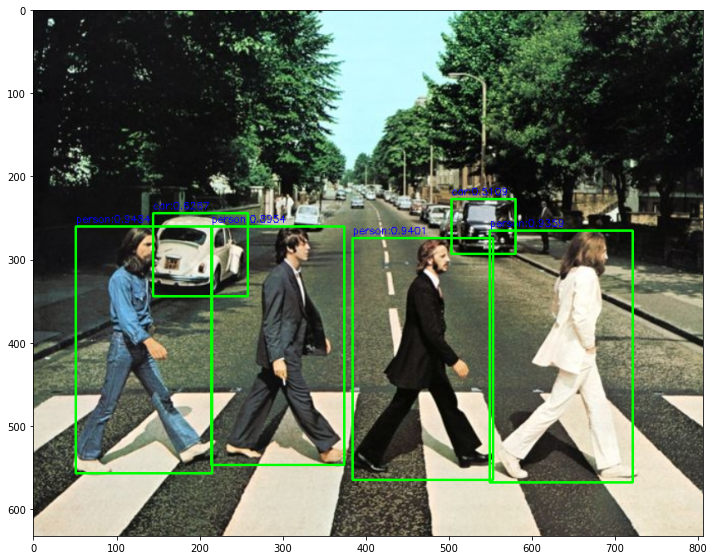

In [62]:
import cv2



# img RGB로 변경
img_rgb = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

draw_img = img_rgb.copy()

draw_img_tensor = tf.convert_to_tensor(draw_img, dtype=tf.uint8)[tf.newaxis, ...]

result = detector_model(draw_img_tensor)
result = {key:value.numpy() for key,value in result.items()}

SCORE_THRESHOLD = 0.5
green_color = (0, 255 ,0)
red_color= (0, 0, 255)
img_width = img_rgb.shape[1]
img_height = img_rgb.shape[0]
scores = result['detection_scores'][0]
boxes = result['detection_boxes'][0]
classes = result['detection_classes'][0]
for i in range(result['detection_classes'].shape[1]):
    score = scores[i]
    box = boxes[i]
    cid = classes[i]

    if score < SCORE_THRESHOLD:
        break
    
    left = box[1] * img_width
    top = box[0] * img_height
    right = box[3] * img_width
    bottom = box[2] * img_height

    class_id = labels_to_names[cid]
    caption = '{}:{:.4f}'.format(class_id, score)
    print(caption)

    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), (int(top)-5)) ,cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)
plt.show()

In [64]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  height = img_array.shape[0]
  width = img_array.shape[1]
  draw_img = img_array.copy()

  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

  start_time = time.time()
  result = model(img_tensor)
  result = {key:value.numpy() for key,value in result.items()}

  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.9484
person: 0.9401
person: 0.9359
person: 0.8954
car: 0.6267
car: 0.5109
Detection 수행시간: 0.32 초


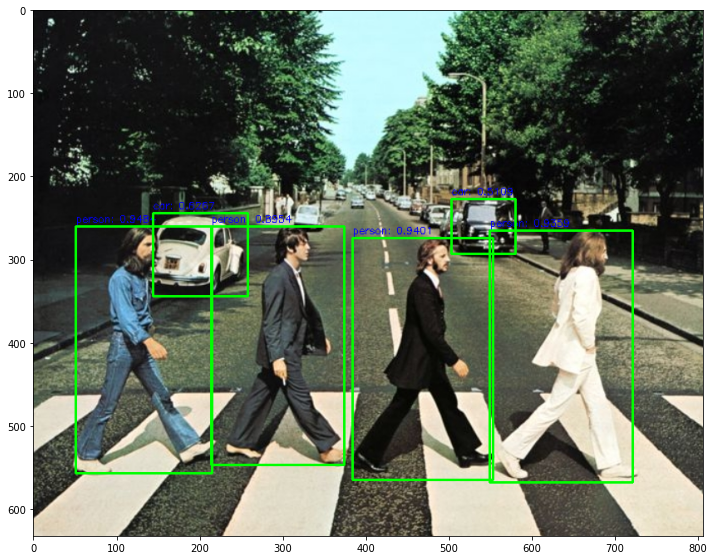

In [65]:
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [66]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2021-09-30 07:56:53--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.01s   

2021-09-30 07:56:53 (6.03 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



person: 0.9570
person: 0.9252
person: 0.9068
baseball glove: 0.6338
baseball bat: 0.5929
Detection 수행시간: 0.3 초


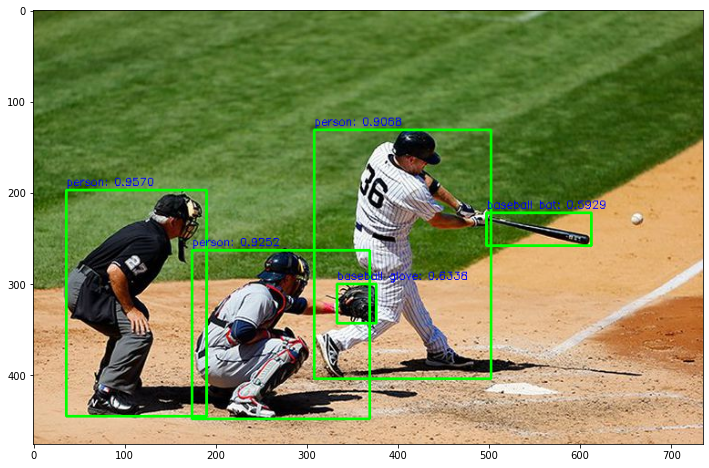

In [67]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [69]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_detector()

In [70]:
detector_model_d2 = get_detector('https://tfhub.dev/tensorflow/efficientdet/d2/1')

person: 0.9488
person: 0.9321
person: 0.8895
baseball glove: 0.8303
baseball bat: 0.6166
sports ball: 0.5037
Detection 수행시간: 7.4 초


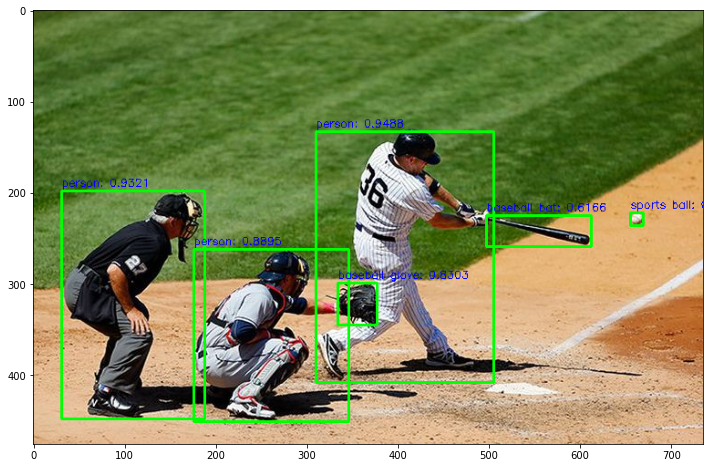

In [71]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [72]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2021-09-30 07:59:59--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2021-09-30 08:00:00--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2021-09-30 08:00:00--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [73]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [ ]:
do_detected_video(detector_model, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5, True)

### EfficientDet lite2 모델로 inference 수행.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import time
import numpy as np

detector_automl_lite0 = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1")

In [77]:
img_array = cv2.imread('/content/data/baseball01.jpg')
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
img_tensor = tf.convert_to_tensor(img_rgb, dtype=tf.uint8)[tf.newaxis, ...]

start_time = time.time()
boxes, scores, classes, num_detections = detector_automl_lite0(img_tensor)
print('수행시간:', time.time() - start_time)

수행시간: 0.03453421592712402


In [81]:
boxes = boxes[0]
scores = scores[0]
classes = classes[0]

In [2]:
# 1부터 91까지의 COCO Class id 매핑. 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [29]:
def get_detected_automl(model, img_array, score_threshold, object_show_count=100, is_print=True):
    draw_img = img_array.copy()

    green_color = (0, 255, 0)
    red_color = (0, 0, 255)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

    start_time = time.time()
    boxes, scores, classes, num_detections = model(img_tensor)
    boxes = boxes[0].numpy()
    scores = scores[0].numpy()
    classes = classes[0].numpy()
    num_detection = num_detections[0]
    
    

    for i in range(num_detection):
        score = scores[i]
        box = boxes[i]
        class_id = classes[i]
        
        if score < score_threshold:
            break

        left = box[1]
        top = box[0]
        right = box[3]
        bottom = box[2]
        

        caption = '{}:{:.4f}'.format(labels_to_names[class_id], score)
        print(class_id)
        print(caption)
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    

    if is_print:
        print('Detection 수행시간:', round(time.time() - start_time ,4))

    return draw_img

1.0
person:0.9009
1.0
person:0.8834
1.0
person:0.8455
Detection 수행시간: 0.0371


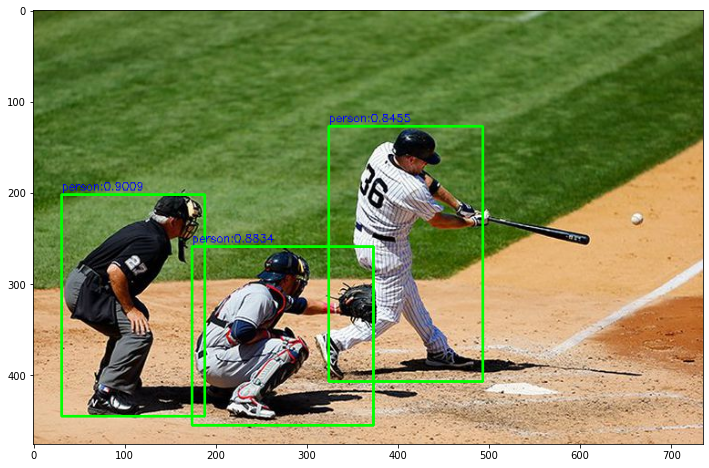

In [30]:
import cv2

img_array = cv2.imread('/content/data/baseball01.jpg')
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
image = get_detected_automl(detector_automl_lite0, img_rgb, score_threshold=0.5, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.show()

### EfficientDet lite2 모델로 inference 수행.

In [31]:
detector_automl_lite2 = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1")

1.0
person:0.9152
1.0
person:0.9089
1.0
person:0.8914
1.0
person:0.8808
3.0
car:0.6071
3.0
car:0.5114
Detection 수행시간: 2.6708


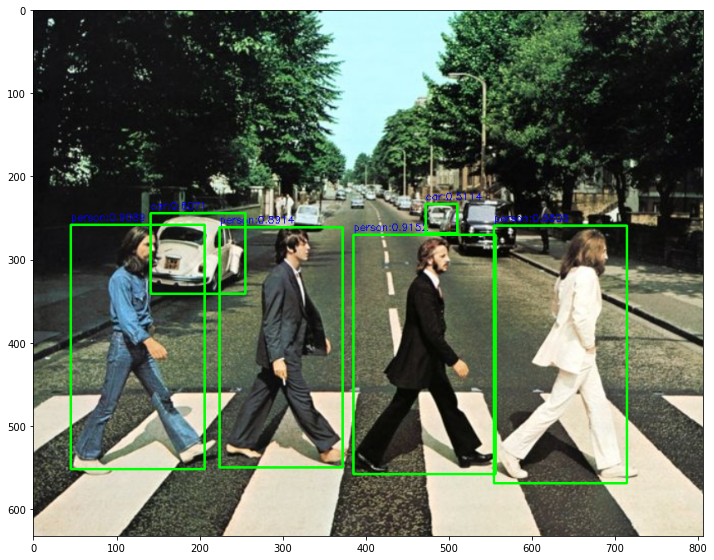

In [33]:
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
draw_img = get_detected_automl(detector_automl_lite2, img_array, score_threshold=0.5, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [34]:
def do_detected_video_automl(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        # get_detected_img_automl() 호출 
        img_frame = get_detected_automl(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [35]:
do_detected_video_automl(detector_automl_lite2, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_lite_02.mp4', 0.5, True)

총 Frame 갯수: 58
3.0
car:0.7213
3.0
car:0.7048
1.0
person:0.6839
3.0
car:0.6667
3.0
car:0.6558
3.0
car:0.5763
Detection 수행시간: 2.0102
3.0
car:0.7208
3.0
car:0.7070
1.0
person:0.6858
3.0
car:0.6600
3.0
car:0.6558
3.0
car:0.5790
Detection 수행시간: 0.0686
3.0
car:0.6072
1.0
person:0.5958
3.0
car:0.5877
3.0
car:0.5727
Detection 수행시간: 0.0682
3.0
car:0.6773
1.0
person:0.6331
3.0
car:0.5557
Detection 수행시간: 0.0627
3.0
car:0.7090
1.0
person:0.6330
3.0
car:0.6061
3.0
car:0.5067
Detection 수행시간: 0.0703
3.0
car:0.6947
3.0
car:0.6896
1.0
person:0.5417
Detection 수행시간: 0.0635
3.0
car:0.6893
3.0
car:0.6833
1.0
person:0.5335
Detection 수행시간: 0.0641
3.0
car:0.7336
3.0
car:0.7109
3.0
car:0.6813
4.0
motorcycle:0.5120
Detection 수행시간: 0.0631
3.0
car:0.7302
3.0
car:0.7150
4.0
motorcycle:0.6327
3.0
car:0.6062
Detection 수행시간: 0.0647
3.0
car:0.7211
3.0
car:0.7191
4.0
motorcycle:0.6324
3.0
car:0.6052
Detection 수행시간: 0.0686
3.0
car:0.7077
3.0
car:0.6678
3.0
car:0.6344
4.0
motorcycle:0.6321
Detection 수행시간: 0.0746
3.0
car: